# 1. 패키지 설치 및 불러오기

In [6]:
# !pip install datasets
# !pip install tensorflow transformers datasets matplotlib scikit-learn
# !pip install numpy pandas tensorflow scikit-learn matplotlib yfinance requests beautifulsoup4 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
# ! pip install numpy pandas tensorflow matplotlib scikit-learn yfinance

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler

# 2. LSTM 모델 구축 (Close만)

In [42]:
# 주식 데이터 불러오기
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')[['Close']]

# 데이터 정규화
scaler = MinMaxScaler()
data['scaled_data'] = scaler.fit_transform(data[['Close']])

# 롤링 윈도우 데이터 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# 파라미터 설정
time_step = 20
batch_size = 32
epochs = 20

# 입력 피처: Close만 사용
X_single, y_single = create_rolling_window(data['scaled_data'].values, time_step)
split = int(len(X_single) * 0.8)
X_train_single, X_test_single = X_single[:split], X_single[split:]
y_train_single, y_test_single = y_single[:split], y_single[split:]

# Single Model 구축
single_model = Sequential([
    Input(shape=(time_step, 1)),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
    Dropout(0.2),
    LSTM(32, kernel_regularizer=l2(1e-5)),
    Dropout(0.2),
    Dense(1)
])

single_model.compile(optimizer=Adam(), loss=Huber())
single_model.fit(X_train_single, y_train_single, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측 수행
y_pred_single = single_model.predict(X_test_single)

# 역정규화
y_test_rescaled = scaler.inverse_transform(y_test_single.reshape(-1, 1)).flatten()
y_pred_rescaled_single = scaler.inverse_transform(y_pred_single).flatten()

# 성능 평가
rmse_single = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled_single))
mae_single = mean_absolute_error(y_test_rescaled, y_pred_rescaled_single)
mape_single = np.mean(np.abs((y_test_rescaled - y_pred_rescaled_single) / y_test_rescaled)) * 100

# 방향성 기반 정확도 계산
accuracy_single = accuracy_score(
    (np.diff(y_test_rescaled) > 0).astype(int),
    (np.diff(y_pred_rescaled_single) > 0).astype(int)
)

# 결과 출력
print(f"Single Model RMSE: {rmse_single:.4f}")
print(f"Single Model MAE: {mae_single:.4f}")
print(f"Single Model MAPE: {mape_single:.4f}%")
print(f"Single Model Accuracy: {accuracy_single:.4f}")

[*********************100%***********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Single Model RMSE: 9.5874
Single Model MAE: 8.7511
Single Model MAPE: 4.8594%
Single Model Accuracy: 0.4619


# 3. LSTM모델 구축(Close + 더 많이)

In [43]:
# 주식 데이터 불러오기 (Open, High, Low, Close, Volume)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]

# 열 이름에서 종목명 제거
data.columns = data.columns.get_level_values(0)

# 정규화 수행
scalers = {}
scaled_data = pd.DataFrame(index=data.index, columns=data.columns)
for col in data.columns:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(data[[col]]).flatten()
    scalers[col] = scaler

# 롤링 윈도우 데이터 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])  # Close 값 예측
    return np.array(X), np.array(y)

# 파라미터 설정
time_step = 20
batch_size = 32
epochs = 20

# 입력 피처: Open, High, Low, Close, Volume 사용
X_multi, y_multi = create_rolling_window(scaled_data, time_step)
split = int(len(X_multi) * 0.8)
X_train_multi, X_test_multi = X_multi[:split], X_multi[split:]
y_train_multi, y_test_multi = y_multi[:split], y_multi[split:]

# Multi Model 구축
multi_model = Sequential([
    Input(shape=(time_step, 5)),  # 5개 입력 피처 사용
    LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
    Dropout(0.2),
    LSTM(32, kernel_regularizer=l2(1e-5)),
    Dropout(0.2),
    Dense(1)
])

multi_model.compile(optimizer=Adam(), loss=Huber())
multi_model.fit(X_train_multi, y_train_multi, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측 수행
y_pred_multi = multi_model.predict(X_test_multi)

# 역정규화 (Close 값만 복원)
y_test_rescaleds = scalers['Close'].inverse_transform(y_test_multi.reshape(-1, 1)).flatten()
y_pred_rescaled_multi = scalers['Close'].inverse_transform(y_pred_multi).flatten()

# 성능 평가
rmse_multi = np.sqrt(mean_squared_error(y_test_rescaleds, y_pred_rescaled_multi))
mae_multi = mean_absolute_error(y_test_rescaleds, y_pred_rescaled_multi)
mape_multi = np.mean(np.abs((y_test_rescaleds - y_pred_rescaled_multi) / y_test_rescaleds)) * 100

# 방향성 기반 정확도 계산
accuracy_multi = accuracy_score(
    (np.diff(y_test_rescaleds) > 0).astype(int),
    (np.diff(y_pred_rescaled_multi) > 0).astype(int)
)

# 결과 출력
print(f"Multi Model RMSE: {rmse_multi:.4f}")
print(f"Multi Model MAE: {mae_multi:.4f}")
print(f"Multi Model MAPE: {mape_multi:.4f}%")
print(f"Multi Model Accuracy: {accuracy_multi:.4f}")

[*********************100%***********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Multi Model RMSE: 4.7381
Multi Model MAE: 3.9647
Multi Model MAPE: 2.2004%
Multi Model Accuracy: 0.4873


# Close 모델과 OHLCV 모델의 성능비교


### Evaluation Comparison ###
            Model      RMSE       MAE      MAPE  Accuracy
0  Single (Close)  9.587404  8.751119  4.859351  0.461929
1   Multi (OHLCV)  4.738056  3.964723  2.200369  0.487310


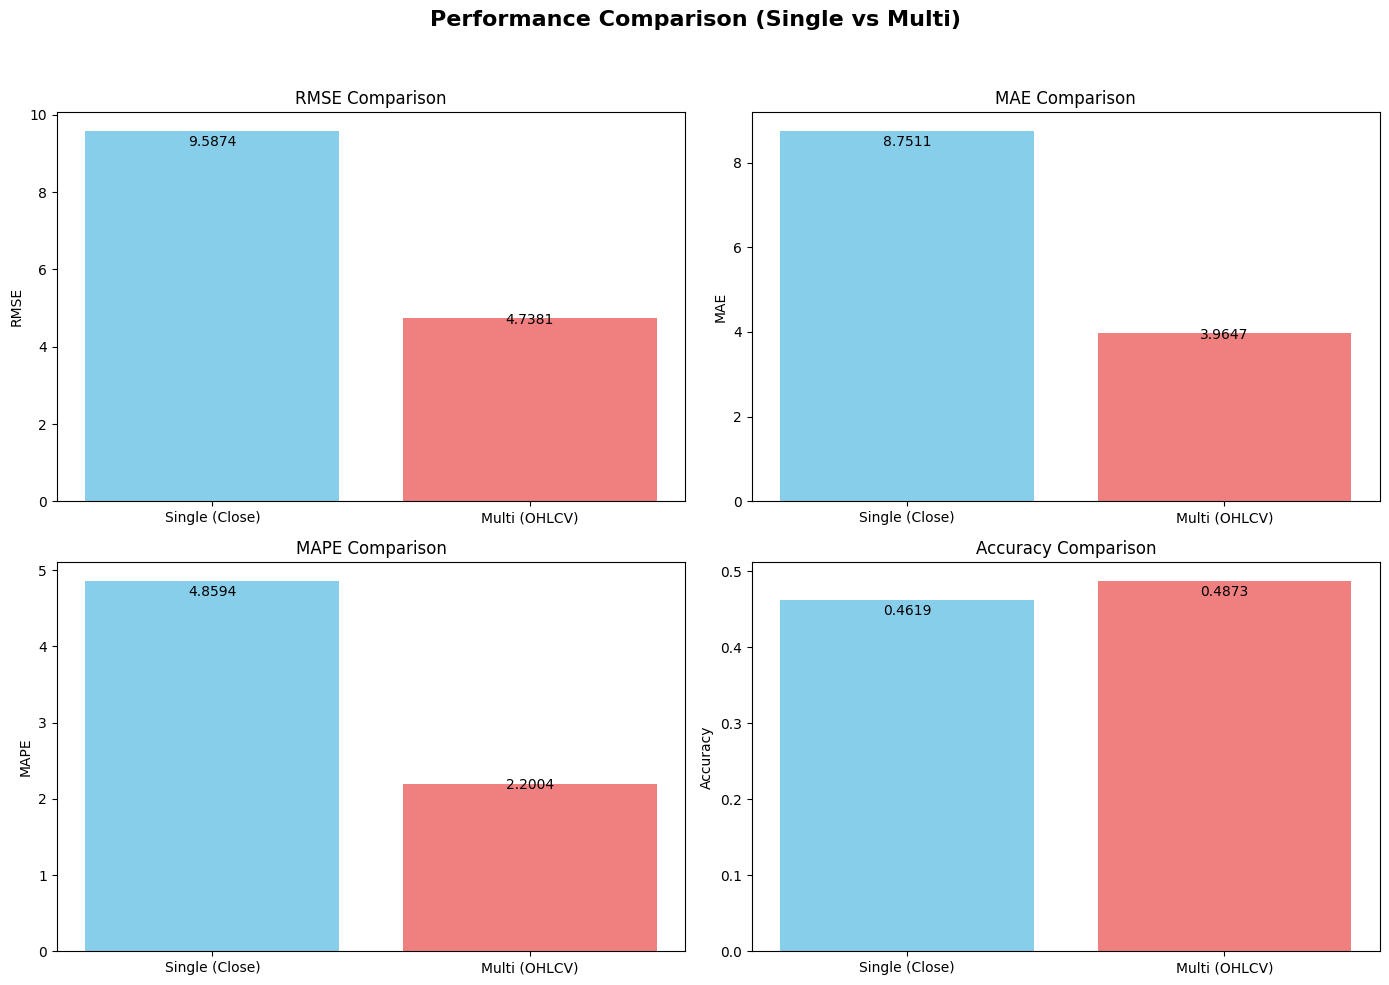

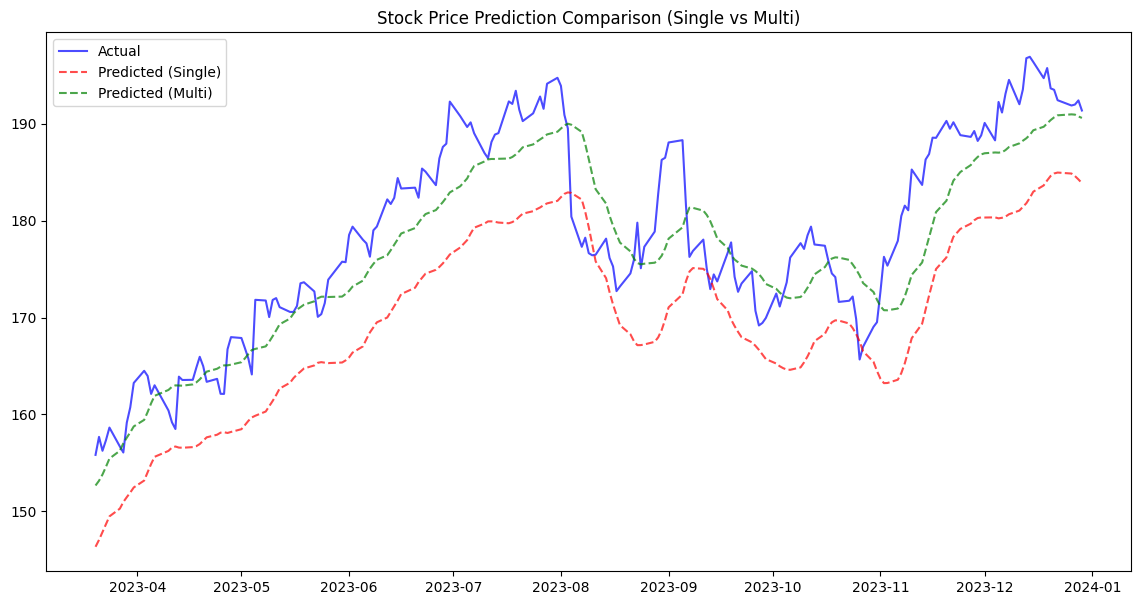

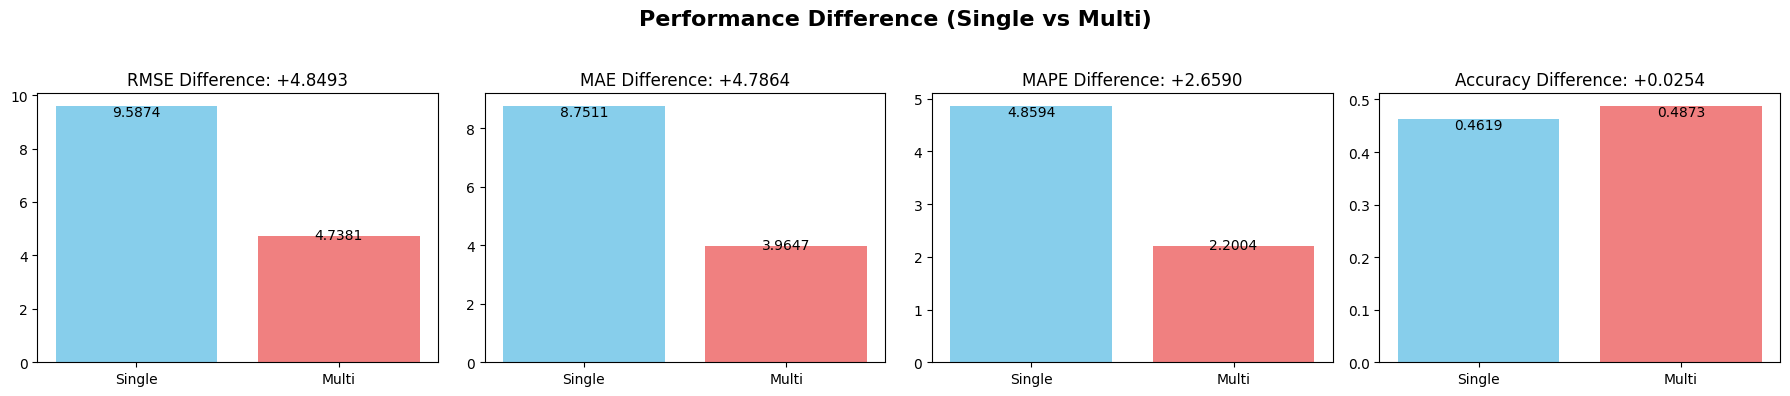

In [46]:
# 성능 비교 표 출력
results = pd.DataFrame({
    'Model': ['Single (Close)', 'Multi (OHLCV)'],
    'RMSE': [rmse_single, rmse_multi],
    'MAE': [mae_single, mae_multi],
    'MAPE': [mape_single, mape_multi],
    'Accuracy': [accuracy_single, accuracy_multi]
})

print("\n### Evaluation Comparison ###")
print(results)

# 성능 비교 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['RMSE', 'MAE', 'MAPE', 'Accuracy']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(['Single (Close)', 'Multi (OHLCV)'], [results.loc[0, metric], results.loc[1, metric]], color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    for j, value in enumerate([results.loc[0, metric], results.loc[1, metric]]):
        ax.text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Performance Comparison (Single vs Multi)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 예측값 비교 시각화
predicted_index = data.index[-len(y_test_rescaled):]

plt.figure(figsize=(14, 7))
plt.plot(predicted_index, y_test_rescaled, label='Actual', color='blue', alpha=0.7)
plt.plot(predicted_index, y_pred_rescaled_single, label='Predicted (Single)', color='red', linestyle='--', alpha=0.7)
plt.plot(predicted_index, y_pred_rescaled_multi, label='Predicted (Multi)', color='green', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Stock Price Prediction Comparison (Single vs Multi)')
plt.show()

# 성능 개선 비교 (차이값 시각화)
fig, ax = plt.subplots(1, 4, figsize=(18, 4))

for i, metric in enumerate(metrics):
    if metric == 'Accuracy':
        # 정확도는 Single이 더 높으면 - 표시
        diff = results.loc[1, metric] - results.loc[0, metric]
    else:
        # 나머지는 Multi가 더 높으면 - 표시
        diff = results.loc[0, metric] - results.loc[1, metric]

    # 차이값에 부호 추가
    sign = '+' if diff > 0 else '-'
    display_diff = f'{sign}{abs(diff):.4f}'

    ax[i].bar(['Single', 'Multi'], [results.loc[0, metric], results.loc[1, metric]], color=colors)
    ax[i].set_title(f'{metric} Difference: {display_diff}')
    for j, value in enumerate([results.loc[0, metric], results.loc[1, metric]]):
        ax[i].text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Performance Difference (Single vs Multi)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()